In [ ]:
import tensorflow as tf
from musicnn_keras import configuration as config
from musicnn_keras.extractor import batch_data
from musicnn_keras.extractor import extractor
import librosa
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt  

In [28]:
model = 'MTT_musicnn'
input_length = 3
input_overlap = False
extract_features = True

Choose an audio file as input
----------

In [30]:
file_name = 'audio/186942__lemoncreme__piano-melody.wav'
labels = config.MTT_LABELS
num_classes = len(labels)

try:
    keras_model = tf.keras.models.load_model('./musicnn_keras/keras_checkpoints/{}.h5'.format(model))
except:
    raise ValueError('Unknown model')

# select labels
if 'MTT' in model:
    labels = config.MTT_LABELS
elif 'MSD' in model:
    labels = config.MSD_LABELS

if 'vgg' in model and input_length != 3:
    raise ValueError('Set input_length=3, the VGG models cannot handle different input lengths.')

In [31]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

def depict_features(thisInput, coordinates, title, aspect='auto', xlabel=True, fontsize=13):
    # plot features in coordinates
    ax = plt.subplot(coordinates) 
    plt.imshow(thisInput.T, interpolation=None, aspect=aspect)
    # set title
    ax.title.set_text(title + ' (' + str(thisInput.shape[1]) + ')' )
    ax.title.set_fontsize(fontsize)
    # y-axis
    ax.get_yaxis().set_visible(False)
    # x-axis
    x_label = np.arange(0, thisInput.shape[0], thisInput.shape[0]//5)
    ax.set_xticks(x_label)
    ax.set_xticklabels(x_label, fontsize=fontsize)
    #if xlabel:
        #ax.set_xlabel('(time frames)', fontsize=fontsize)


In [32]:
# convert seconds to frames
n_frames = librosa.time_to_frames(input_length, sr=config.SR, n_fft=config.FFT_SIZE, hop_length=config.FFT_HOP) + 1
if not input_overlap:
    overlap = n_frames
else:
    overlap = librosa.time_to_frames(input_overlap, sr=config.SR, n_fft=config.FFT_SIZE, hop_length=config.FFT_HOP)


In [33]:
feature_nums = 50
#feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

batch, spectrogram = batch_data(file_name, n_frames, overlap)

batch1 = batch[0, :,  :]
#print(tf.shape(batch1))

#print('Total number of feature channels:', feature_nums)

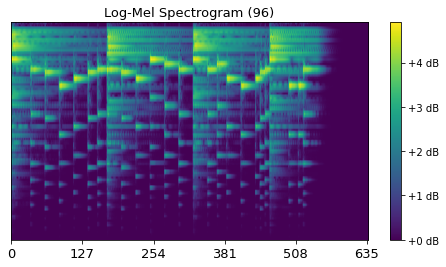

In [34]:
plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 1) # create a figure having 1 rows and 1 cols.
depict_features(thisInput=spectrogram,
                coordinates=gs[0, 0],
                title='Log-Mel Spectrogram',
                aspect='auto')

plt.colorbar(format='%+2.0f dB')
plt.savefig("Outputs/logMel.png",bbox_inches = 'tight')
plt.show()

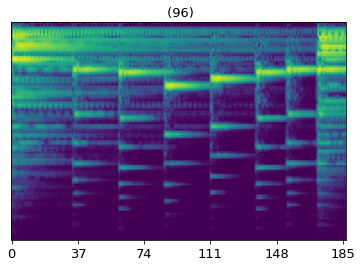

In [35]:
# # start with a gray image with a little noise
# upper = np.max(batch1)
# lower = np.min(batch1)
# #print(upper)
# img_noise = np.random.uniform(low = lower, high = upper, size = (187, 96))
# thisInput = np.float32(img_noise)
# print(np.min(thisInput),np.max(thisInput),np.mean(thisInput))


thisInput = batch1
gs = gridspec.GridSpec(1, 1) # create a figure having 1 rows and 1 cols.
depict_features(thisInput=thisInput,
                coordinates=gs[0, 0],
                title='',
                aspect='auto')
plt.show()

audio_out01 = librosa.feature.inverse.mel_to_audio(M=thisInput.T,
                                               sr=config.SR,
                                               hop_length=config.FFT_HOP,
                                               n_fft=config.FFT_SIZE)

# librosa.output.write_wav('Audio_out000.wav', audio_out01, config.SR) 



Create the feature extraction model
------

In [36]:
total_variation_weight = 0.000001
#layerOut = y
#channel = 0

#names = ['tf_op_layer_Max','tf_op_layer_moments/Squeeze','tf_op_layer_transpose_2','tf_op_layer_transpose_1','tf_op_layer_transpose','tf_op_layer_concat','bn_dense']
names = ['bn_dense']


#names = ['dense_1']
layers = [keras_model.get_layer(name).output for name in names]


#uncomment the next line if use the model without taggram 
# dream_model = tf.keras.Model(keras_model.input, layers)



Uncomment the next cell if you want to use the model with taggram


In [37]:
x1 = tf.keras.layers.Dropout(rate=0.5)(layers)
x2 = tf.keras.layers.Dense(activation=None, units=num_classes)(x1)
x3 = tf.keras.layers.Activation('sigmoid')(x2)
dream_model = tf.keras.Model(keras_model.input, x3)

In [38]:
def calc_loss(thisInput, model):
  channel = 3
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  input_batch = tf.expand_dims(thisInput, axis=0)
  input_batch = tf.expand_dims(input_batch, 3)
  layer_activations = model(input_batch)
  this_class = layer_activations
  layer_activations = tf.reshape(layer_activations[0,0,2],(1,1,1))
  
  print ("Layer_activtations{}".format(np.shape(this_class)),layer_activations)

  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act[0])
    #loss = tf.math.abs(this_class)

    losses.append(loss)
  #return this_class
  #return  tf.reduce_sum(tf.math.abs(this_class))
  return  tf.reduce_sum(losses)

In [39]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, thisInput, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(thisInput)
          loss = calc_loss(thisInput, self.model)
          loss = loss+total_variation_weight*tf.image.total_variation(tf.expand_dims(thisInput, axis=2))

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, thisInput)
        print(gradients)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        thisInput = thisInput + gradients*step_size
        #thisInput = tf.clip_by_value(thisInput, 0, 1.0*upper)
        print ("Step {}, loss {}, step_size {}".format(n, loss, step_size))
      return loss, thisInput

In [40]:
deepdream = DeepDream(dream_model)

In [41]:
def run_deep_dream_simple(thisInput, steps=100, step_size=0.005):
  # Convert from uint8 to the range expected by the model.

  thisInput = tf.convert_to_tensor(thisInput)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, thisInput = deepdream(thisInput, run_steps, tf.constant(step_size))

    print ("Step {}, loss {}, stepsize {}".format(step, loss, step_size))


  result = thisInput

  return result

Tracing
Layer_activtations(1, 1, 50) Tensor("Reshape:0", shape=(1, 1, 1), dtype=float32)
Tensor("AddN_9:0", shape=(None, None), dtype=float32)
Step Tensor("Placeholder:0", shape=(), dtype=int32), loss Tensor("add:0", shape=(), dtype=float32), step_size Tensor("step_size:0", shape=(), dtype=float32)
Step 100, loss 1.0245258808135986, stepsize 0.004999999888241291


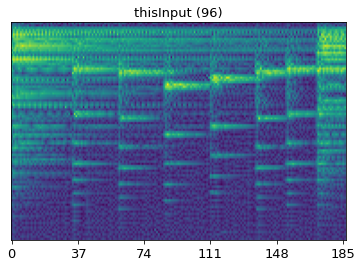

FileNotFoundError: [Errno 2] No such file or directory: 'nightmare-audio\\Outputs\\piano_to_slow/Audio_out001.wav'

In [42]:
dream_img3 = run_deep_dream_simple(thisInput,100, 0.005)
#print(tf.shape(thisInput))

#print(dream_img)
dream_img3= np.array(dream_img3)

gs = gridspec.GridSpec(1, 1) # create a figure having 1 rows and 1 cols.
depict_features(thisInput=dream_img3,
                coordinates=gs[0, 0],
                title='thisInput',
                aspect='auto')
plt.show()

# audio_out01 = librosa.feature.inverse.mel_to_audio(M=dream_img2.T,
#                                                sr=config.SR,
#                                                hop_length=config.FFT_HOP,
#                                                n_fft=config.FFT_SIZE)

#librosa.output.write_wav('outTest/audio_out00.wav', audio_out00, config.SR) 


audio_rep3 = (np.power(10.0, dream_img3)-1.0)/10000.0


audio_out04 = librosa.feature.inverse.mel_to_audio(M=audio_rep3.T,
                                               sr=config.SR,
                                               hop_length=config.FFT_HOP,
                                               n_fft=config.FFT_SIZE)

librosa.output.write_wav('nightmare-audio\Outputs\piano_to_slow/Audio_out001.wav', audio_out04, config.SR)

In [43]:
dream_img6 = run_deep_dream_simple(thisInput,500 , 0.001)

dream_img6= np.array(dream_img6)


gs = gridspec.GridSpec(1, 1) # create a figure having 1 rows and 1 cols.
depict_features(thisInput=dream_img6,
                coordinates=gs[0, 0],
                title='this',
                aspect='auto')
plt.show()

audio_rep6 = (np.power(10.0, dream_img6)-1.0)/10000.0


audio_out07 = librosa.feature.inverse.mel_to_audio(M=audio_rep6.T,
                                               sr=config.SR,
                                               hop_length=config.FFT_HOP,
                                               n_fft=config.FFT_SIZE)

librosa.output.write_wav('nightmare-audio\Outputs\piano_to_slow/Audio_out002.wav', audio_out07, config.SR)

Step 100, loss 1.0068999528884888, stepsize 0.0010000000474974513
Step 200, loss 1.0123872756958008, stepsize 0.0010000000474974513


Step 100, loss 0.7540379166603088, stepsize 0.0005000000237487257
Step 200, loss 0.8601595759391785, stepsize 0.0005000000237487257
Step 300, loss 0.9194992184638977, stepsize 0.0005000000237487257
Step 400, loss 0.9511891603469849, stepsize 0.0005000000237487257
Step 500, loss 0.9729634523391724, stepsize 0.0005000000237487257
Step 600, loss 0.9867413640022278, stepsize 0.0005000000237487257
Step 700, loss 0.9962087273597717, stepsize 0.0005000000237487257
Step 800, loss 1.0011810064315796, stepsize 0.0005000000237487257
Step 900, loss 1.0046230554580688, stepsize 0.0005000000237487257
Step 1000, loss 1.0070977210998535, stepsize 0.0005000000237487257


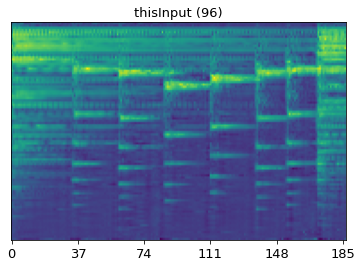

FileNotFoundError: [Errno 2] No such file or directory: 'piano_to_slow/Audio_out003.wav'

In [26]:
dream_img = run_deep_dream_simple(thisInput,1000, 0.0005)
#print(tf.shape(thisInput))

#print(dream_img)
dream_img= np.array(dream_img)

gs = gridspec.GridSpec(1, 1) # create a figure having 1 rows and 1 cols.
depict_features(thisInput=dream_img,
                coordinates=gs[0, 0],
                title='thisInput',
                aspect='auto')
plt.show()




audio_rep = (np.power(10.0, dream_img)-1.0)/10000.0



audio_out01 = librosa.feature.inverse.mel_to_audio(M=audio_rep.T,
                                               sr=config.SR,
                                               hop_length=config.FFT_HOP,
                                               n_fft=config.FFT_SIZE)

librosa.output.write_wav('nightmare-audio\Outputs\piano_to_slow/Audio_out003.wav', audio_out01, config.SR)    

the step of 5000 requires a lot of time computing and it seems not increase the final score so uncomment the next below unless you need to do further validation.

In [29]:
# dream_img2 = run_deep_dream_simple(thisInput,5000, 0.0001)
# #print(tf.shape(thisInput))

# #print(dream_img)
# dream_img2= np.array(dream_img2)

# gs = gridspec.GridSpec(1, 1) # create a figure having 1 rows and 1 cols.
# depict_features(thisInput=dream_img2,
#                 coordinates=gs[0, 0],
#                 title='thisInput',
#                 aspect='auto')
# plt.show()


# audio_rep2 = (np.power(10.0, dream_img2)-1.0)/10000.0


# audio_out03 = librosa.feature.inverse.mel_to_audio(M=audio_rep2.T,
#                                                sr=config.SR,
#                                                hop_length=config.FFT_HOP,
#                                                n_fft=config.FFT_SIZE)

# librosa.output.write_wav('piano_to_classic/Audio_out004.wav', audio_out03, config.SR)    